In [1]:
import sys
import os
import equinox as eqx
import jax.tree_util as jtu
import pandas as pd
import sqlalchemy
import seaborn as sns
import matplotlib.pyplot as plt
import pub_ready_plots
from pub_ready_plots import get_mpl_rcParams
sys.path.append("../../..")
from lib.ml.experiment import Experiment 
from lib.base import Config
from lib.utils import load_config 
from lib.ehr import TVxEHR
import jax

jax.config.update("jax_enable_x64", True)

rc_params, fig_width_in, fig_height_in = pub_ready_plots.get_mpl_rcParams(
    width_frac=1,  # between 0 and 1
    height_frac=0.2,  # between 0 and 1
    layout="jmlr"  # or "iclr", "neurips", "poster-portrait", "poster-landscape"
)
rc_params['figure.constrained_layout.use'] = True
plt.rcParams.update(rc_params)



RESULTS_DIR = "aki_evals"
CONFIGS_DIR = f"{RESULTS_DIR}/configs"
db_name = [
    f"{RESULTS_DIR}/seg_evals.sqlite",
    f"{RESULTS_DIR}/seg_emergency_evals.sqlite",
    f"{RESULTS_DIR}/bin_evals.sqlite",
    f"{RESULTS_DIR}/baselines.sqlite"
]





## 30-Nov Note

From this Notebook, we will generate the results of ICNN (temporal section).
It will also feed into the Koopman imputation results.

In [2]:

def model_name(exp):
    if 'inicenodelite_' in exp:
        return 'eICE-NODE'
    if 'inicenodeliteicnn_' in exp:
        return 'ODE-ICNN'
    if 'inicenodelitemech_' in exp:
        return 'mICE-NODE'
    if 'inicenodelitestochastic_' in exp:
        return 'sICE-NODE'
    if 'gruodebayes' in exp:
        return 'GRU-ODE-Bayes'
    if 'ingru' in exp:
        return 'GRU-TB'
    if 'inkoopman' in exp:
        return 'Koopman'
    if 'inicenodeliteicnn' in exp:
        return 'ODE-ICNN'
    if 'rectilinear' in exp:
        return 'RectiLinear'
    if 'innaivesequentialgru' in exp:
        return 'GRU-Sequential'
    assert False
    
def loss_name(exp):
    if 'mse' in exp:
        return 'mse'
    if 'bce' in exp:
        return 'bce'
    if 'rectilinear' in exp or 'innaivesequentialgru' in exp:
        return 'mse'
    assert False

def predictor_name(exp):    
    if exp.startswith('mlp'):
        return 'mlp'
    if exp.startswith('monotonic'):
        return 'monotonic'
    if 'rectilinear' in exp or 'innaivesequentialgru' in exp:
        if 'mlp' in exp:
            return 'mlp'
        if 'mono' in exp:
            return 'monotonic'
    assert False

def batch_size(exp):
    if 'rectilinear' in exp or 'innaivesequentialgru' in exp:
        return 2

    if 'B2' in exp:
        return 2
    else:
        return 64

    assert False

def icenode_dyn(exp):
    if 'Koopman' in exp:
        return 'NA'
    if 'inicenodelite_gru_' in exp or 'grudyn' in exp:
        return 'gru'
    if 'inicenodelite' in exp or 'mlpdyn' in exp:
        return 'mlp'
    else:
        return 'NA'

def optimiser(exp):
    if 'adam' in exp:
        return 'adam'
    if 'lamb' in exp:
        return 'lamb'
    if 'novograd' in exp:
        return 'novograd'
    return 'adam'
        


def sql2dataframe(db):
    engine = sqlalchemy.create_engine("sqlite:///%s" % db, execution_options={"sqlite_raw_colnames": True},
                                     connect_args={'timeout': 5})
    
    df = {name: pd.read_sql_table(name, engine) for name in 
          ('evaluation_runs', 'evaluation_status', 'experiments', 'metrics', 'results')}
    df['results']
    
    metrics = df['metrics'].rename(columns={'name': 'metric', 'id': 'metric_id'})
    eval_runs = df['evaluation_runs'].rename(columns={'id': 'evaluation_id'})
    experiments = df['experiments'].rename(columns={'name': 'experiment', 'id': 'experiment_id'})
    eval_status = df['evaluation_status'].rename(columns={'id': 'status_id', 'name': 'status'})
    
    res = pd.merge(df['results'], metrics, left_on='metric_id', right_on='metric_id', how='left')
    res = pd.merge(res, eval_runs, left_on='evaluation_id', right_on='evaluation_id', how='left')
    res = pd.merge(res, experiments, left_on='experiment_id', right_on='experiment_id', how='left')
    res = pd.merge(res, eval_status, left_on='status_id', right_on='status_id', how='left')
    res['step'] = res.snapshot.str.extract('(\d+)').astype(int)

    res = res.sort_values(['experiment_id', 'step'])
    res['last_max'] = float('nan')
    res['last_min'] = float('nan')
    res['is_max'] = False
    res['is_min'] = False
    res['max'] = float('nan')
    res['min'] = float('nan')
    
    for exp, exp_df in res.groupby('experiment_id'):
        for metric, metric_df in exp_df.groupby('metric'):
            index = metric_df.index
            res.loc[index, 'last_max'] = metric_df['value'].cummax()
            res.loc[index, 'last_min'] = metric_df['value'].cummin()
            res.loc[index, 'is_max'] = metric_df['value'] == res.loc[index, 'last_max']
            res.loc[index, 'is_min'] = metric_df['value'] == res.loc[index, 'last_min']
            res.loc[index, 'max'] = metric_df['value'].max()
            res.loc[index, 'min'] = metric_df['value'].min()
            
    
    res = res[[col for col in res.columns if 'id' not in col]]

    res['model'] = res.experiment.map(model_name)
    res['loss'] = res.experiment.map(loss_name)
    res['predictor'] = res.experiment.map(predictor_name)
    res['batch_size'] = res.experiment.map(batch_size)
    res['icenode_dyn'] = res.experiment.map(icenode_dyn)
    res['optimiser'] = res.experiment.map(icenode_dyn)
    return res


def experiment_mincost_snapshots(dataframe, 
                                 cost_metrics = [ 'LeadPredictionLossMetric.mse']):
    def experiment_step_min_cost(experiment_df):
        return pd.Series({'best_step': experiment_df.loc[experiment_df['value'].idxmin(), 'step']})
        
    results2 = dataframe[dataframe.metric.isin(cost_metrics)]
    results2 = results2[['experiment', 'step', 'value']].groupby(['experiment', 'step']).sum().reset_index()
    results2 = results2.groupby('experiment').apply(experiment_step_min_cost).reset_index()
    return results2.set_index('experiment')['best_step'].to_dict()




In [3]:
results = pd.concat([sql2dataframe(db) for db in db_name])

In [4]:
best_experiment_snapshot = experiment_mincost_snapshots(results)

In [5]:
results

,value,metric,created_at,updated_at,snapshot,experiment,status,step,last_max,last_min,is_max,is_min,max,min,model,loss,predictor,batch_size,icenode_dyn,optimiser
32096,7.243400e+04,LeadingAKIPredictionAccuracy.n_timestamps_nega...,2024-09-16 10:35:22.801213,2024-09-18 00:50:22.326970,step0990.eqx,monotonic_bce_inicenodelite_gru_g0,FINISHED,990,7.243400e+04,7.243400e+04,True,True,7.243400e+04,7.243400e+04,eICE-NODE,bce,monotonic,64,gru,gru
32097,NaN,LeadingAKIPredictionAccuracy.n_timestamps_unknown,2024-09-16 10:35:22.801213,2024-09-18 00:50:22.326970,step0990.eqx,monotonic_bce_inicenodelite_gru_g0,FINISHED,990,NaN,NaN,False,False,NaN,NaN,eICE-NODE,bce,monotonic,64,gru,gru
32098,8.929600e+04,LeadingAKIPredictionAccuracy.n_timestamps_firs...,2024-09-16 10:35:22.801213,2024-09-18 00:50:22.326970,step0990.eqx,monotonic_bce_inicenodelite_gru_g0,FINISHED,990,8.929600e+04,8.929600e+04,True,True,8.929600e+04,8.929600e+04,eICE-NODE,bce,monotonic,64,gru,gru
32099,5.330500e+04,LeadingAKIPredictionAccuracy.n_timestamps_late...,2024-09-16 10:35:22.801213,2024-09-18 00:50:22.326970,step0990.eqx,monotonic_bce_inicenodelite_gru_g0,FINISHED,990,5.330500e+04,5.330500e+04,True,True,5.330500e+04,5.330500e+04,eICE-NODE,bce,monotonic,64,gru,gru
32100,NaN,LeadingAKIPredictionAccuracy.n_timestamps_reco...,2024-09-16 10:35:22.801213,2024-09-18 00:50:22.326970,step0990.eqx,monotonic_bce_inicenodelite_gru_g0,FINISHED,990,NaN,NaN,False,False,NaN,NaN,eICE-NODE,bce,monotonic,64,gru,gru
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1411,7.203979e-01,ObsPredictionLossMetric.mae,2024-11-29 19:48:47.113689,2024-11-29 21:32:13.849781,step0360.eqx,innaivesequentialgru_mono_g0,FINISHED,360,7.203979e-01,7.203979e-01,True,True,7.203979e-01,7.203979e-01,GRU-Sequential,mse,monotonic,2,NA,NA
1412,8.941732e-01,ObsPredictionLossMetric.mse,2024-11-29 19:48:47.113689,2024-11-29 21:32:13.849781,step0360.eqx,innaivesequentialgru_mono_g0,FINISHED,360,8.941732e-01,8.941732e-01,True,True,8.941732e-01,8.941732e-01,GRU-Sequential,mse,monotonic,2,NA,NA
1413,-inf,ObsPredictionLossMetric.r2,2024-11-29 19:48:47.113689,2024-11-29 21:32:13.849781,step0360.eqx,innaivesequentialgru_mono_g0,FINISHED,360,-inf,-inf,True,True,-inf,-inf,GRU-Sequential,mse,monotonic,2,NA,NA
1414,9.244044e-01,ObsPredictionLossMetric.rms,2024-11-29 19:48:47.113689,2024-11-29 21:32:13.849781,step0360.eqx,innaivesequentialgru_mono_g0,FINISHED,360,9.244044e-01,9.244044e-01,True,True,9.244044e-01,9.244044e-01,GRU-Sequential,mse,monotonic,2,NA,NA


In [6]:
best_experiment_snapshot

{'innaivesequentialgru_mlp_g0': 4490,
 'innaivesequentialgru_mono_g0': 360,
 'mlp_bce_inicenodelite_g0_B2': 98500,
 'mlp_mse_ingru_g0': 14290,
 'mlp_mse_inicenodelite_adam_mlpdyn': 400,
 'mlp_mse_inicenodelite_g0': 990,
 'mlp_mse_inicenodelite_grudyn_adam_grudyn': 2880,
 'mlp_mse_inicenodelite_grudyn_lamb_grudyn': 7010,
 'mlp_mse_inicenodelite_lamb_mlpdyn': 3510,
 'mlp_mse_inicenodelite_novograd_mlpdyn': 7610,
 'mlp_mse_inicenodeliteicnn_adam_mlpdyn': 990,
 'mlp_mse_inicenodeliteicnn_g0': 260,
 'mlp_mse_inicenodeliteicnn_grudyn_adam_g0': 1120,
 'mlp_mse_inicenodeliteicnn_lamb_mlpdyn': 990,
 'mlp_mse_inicenodeliteicnn_novograd_mlpdyn': 560,
 'mlp_mse_inicenodelitemech_novograd_mlpdyn': 50,
 'mlp_mse_inicenodelitestochastic_novograd_mlpdyn': 540,
 'mlp_mse_inkoopman_adam_g0': 990,
 'mlp_mse_inkoopman_adam_mlpdyn': 110,
 'mlp_mse_inkoopman_g0': 2290,
 'mlp_mse_inkoopman_lamb_mlpdyn': 3140,
 'mlp_mse_inkoopman_novograd_g0': 1120,
 'monotonic_bce_gruodebayes_g0': 120,
 'monotonic_bce_ingru_

In [7]:
experiments = pd.DataFrame(results.experiment.unique(), columns=['label'])
experiments['model'] = experiments.label.map(model_name)
experiments['loss'] = experiments.label.map(loss_name)
experiments['predictor'] = experiments.label.map(predictor_name)
experiments['batch_size'] = experiments.label.map(batch_size)
experiments['icenode_dyn'] =  experiments.label.map(icenode_dyn)
experiments['optimiser'] = experiments.label.map(optimiser)
experiments = experiments.set_index(['model', 'icenode_dyn', 'loss', 'predictor', 'batch_size', 'optimiser']).sort_index()
experiments.index.is_unique
experiments

label
model          icenode_dyn loss predictor batch_size optimiser                                                 
GRU-ODE-Bayes  NA          bce  monotonic 64         adam                          monotonic_bce_gruodebayes_g0
GRU-Sequential NA          mse  mlp       2          adam                           innaivesequentialgru_mlp_g0
                                monotonic 2          adam                          innaivesequentialgru_mono_g0
GRU-TB         NA          bce  monotonic 64         adam                                monotonic_bce_ingru_g0
                           mse  mlp       64         adam                                      mlp_mse_ingru_g0
                                monotonic 64         adam                                monotonic_mse_ingru_g0
Koopman        NA          bce  monotonic 64         adam                            monotonic_bce_inkoopman_g0
                           mse  mlp       64         adam                                  mlp_mse_inkoopman_g0
                                                     adam                             mlp_mse_inkoopman_adam_g0
                                                     novograd                     mlp_mse_inkoopman_novograd_g0
                                monotonic 64         adam                            monotonic_mse_inkoopman_g0
               mlp         mse  mlp       64         adam                         mlp_mse_inkoopman_adam_mlpdyn
                                                     lamb                         mlp_mse_inkoopman_lamb_mlpdyn
ODE-ICNN       gru         mse  mlp       64         adam              mlp_mse_inicenodeliteicnn_grudyn_adam_g0
               mlp         bce  monotonic 64         adam                    monotonic_bce_inicenodeliteicnn_g0
                           mse  mlp       64         adam                          mlp_mse_inicenodeliteicnn_g0
                                                     adam                 mlp_mse_inicenodeliteicnn_adam_mlpdyn
                                                     lamb                 mlp_mse_inicenodeliteicnn_lamb_mlpdyn
                                                     novograd         mlp_mse_inicenodeliteicnn_novograd_mlpdyn
                                monotonic 64         adam                    monotonic_mse_inicenodeliteicnn_g0
RectiLinear    NA          mse  mlp       2          adam                                    rectilinear_mlp_g0
                                monotonic 2          adam                                   rectilinear_mono_g0
eICE-NODE      gru         bce  monotonic 64         adam                    monotonic_bce_inicenodelite_gru_g0
                           mse  mlp       64         adam              mlp_mse_inicenodelite_grudyn_adam_grudyn
                                                     lamb              mlp_mse_inicenodelite_grudyn_lamb_grudyn
               mlp         bce  mlp       2          adam                           mlp_bce_inicenodelite_g0_B2
                                monotonic 64         adam                        monotonic_bce_inicenodelite_g0
                           mse  mlp       64         adam                              mlp_mse_inicenodelite_g0
                                                     adam                     mlp_mse_inicenodelite_adam_mlpdyn
                                                     lamb                     mlp_mse_inicenodelite_lamb_mlpdyn
                                                     novograd             mlp_mse_inicenodelite_novograd_mlpdyn
                                monotonic 64         adam                        monotonic_mse_inicenodelite_g0
mICE-NODE      mlp         mse  mlp       64         novograd         mlp_mse_inicenodelitemech_novograd_mlpdyn
sICE-NODE      mlp         mse  mlp       64         novograd   mlp_mse_inicenodelitestochastic_novograd_mlpdyn

In [8]:
# experiments.model.unique()

In [9]:
# results.metric.unique()
results.groupby('experiment')['step'].unique()

experiment
innaivesequentialgru_mlp_g0                        [3490, 3990, 4490, 4990, 5490, 5990, 6490, 699...
innaivesequentialgru_mono_g0                                                                   [360]
mlp_bce_inicenodelite_g0_B2                                                          [98500, 114000]
mlp_mse_ingru_g0                                   [14190, 14290, 14390, 14490, 14590, 14690, 147...
mlp_mse_inicenodelite_adam_mlpdyn                  [340, 370, 400, 5990, 6490, 6900, 12900, 14370...
mlp_mse_inicenodelite_g0                           [990, 1990, 2990, 3990, 4990, 5490, 5990, 6490...
mlp_mse_inicenodelite_grudyn_adam_grudyn              [340, 380, 480, 2880, 3210, 6490, 6800, 11590]
mlp_mse_inicenodelite_grudyn_lamb_grudyn                                                      [7010]
mlp_mse_inicenodelite_lamb_mlpdyn                                 [350, 380, 3510, 5990, 6490, 6980]
mlp_mse_inicenodelite_novograd_mlpdyn                                 [310, 4030

In [10]:
results.groupby('experiment')['step'].unique()

experiment
innaivesequentialgru_mlp_g0                        [3490, 3990, 4490, 4990, 5490, 5990, 6490, 699...
innaivesequentialgru_mono_g0                                                                   [360]
mlp_bce_inicenodelite_g0_B2                                                          [98500, 114000]
mlp_mse_ingru_g0                                   [14190, 14290, 14390, 14490, 14590, 14690, 147...
mlp_mse_inicenodelite_adam_mlpdyn                  [340, 370, 400, 5990, 6490, 6900, 12900, 14370...
mlp_mse_inicenodelite_g0                           [990, 1990, 2990, 3990, 4990, 5490, 5990, 6490...
mlp_mse_inicenodelite_grudyn_adam_grudyn              [340, 380, 480, 2880, 3210, 6490, 6800, 11590]
mlp_mse_inicenodelite_grudyn_lamb_grudyn                                                      [7010]
mlp_mse_inicenodelite_lamb_mlpdyn                                 [350, 380, 3510, 5990, 6490, 6980]
mlp_mse_inicenodelite_novograd_mlpdyn                                 [310, 4030

In [11]:
results.set_index(['model', 'icenode_dyn', 'loss', 'predictor', 'batch_size', 'optimiser']).sort_index().index.is_unique

False

In [12]:


def make_selection(results_dataframe, selectors):
    y = results_dataframe
    for k, vs in selectors.items():
        y = y[y[k].isin(vs)]
    return y


## AUC bar plots (eICE-NODE, GRUODEBayes, GRU)

In [13]:
auc_results_df = make_selection(results, selectors = {
    # 'metric': [
        # 'PerColumnObsPredictionLoss.mean(mse)',
        # 'LeadPredictionLossMetric.mse',
        # 'ObsPredictionLossMetric.mse'
        # 'LeadingAKIPredictionAccuracy.AUC_first_pre_emergence_6.0-48.0',
        # 'LeadingAKIPredictionAccuracy.AUC_pre_emergence_6.0-48.0',
           # 'LeadingAKIPredictionAccuracy.AUC_first_pre_emergence_12.0-48.0',
        # 'LeadingAKIPredictionAccuracy.AUC_pre_emergence_12.0-48.0', 
            # 'LeadingAKIPredictionAccuracy.AUC_first_pre_emergence_24.0-48.0',
        # 'LeadingAKIPredictionAccuracy.AUC_pre_emergence_24.0-48.0',
        # 'LeadingAKIPredictionAccuracy.AUC_first_pre_emergence_36.0-48.0',
        # 'LeadingAKIPredictionAccuracy.AUC_pre_emergence_36.0-48.0'
    # ],
    # 'model': [
        # 'eICE-NODE', 
        # 'GRU-ODE-Bayes', 
        # 'GRU'
    # ],
    # 'predictor': [
    #     'mlp',
    #     'monotonic'
    # ],
    # 'icenode_dyn': [
    #     'mlp', 
    #     'gru', 
    #     'NA'
    # ],
    # 'loss': [
    #     'mse', 
    #     'bce'
    # ],
    # 'batch_size':
    # [
    #     64,
    #     2
    # ],
    'experiment': 
    [
        "mlp_mse_inicenodelite_g0", 
        "monotonic_bce_gruodebayes_g0", 
        # "mlp_mse_ingru_g0",
        "innaivesequentialgru_mlp_g0",
        # "innaivesequentialgru_mono_g0",
        "rectilinear_mlp_g0",
        # "rectilinear_mono_g0"
        "mlp_mse_inkoopman_g0"
    ]
})

experiments_map = {
        # "monotonic_bce_inicenodelite_gru_g0": "eICE-NODE", 
    "mlp_mse_inicenodelite_g0": "eICE-NODE", 
    "monotonic_bce_gruodebayes_g0": "GRU-ODE-Bayes",
    "innaivesequentialgru_mlp_g0": "GRU-Sequential",
    "rectilinear_mlp_g0": "Rectilinear",
    # "mlp_mse_ingru_g0": "GRU-TB",
    "mlp_mse_inkoopman_g0": "ICE-Koopman"
}

auc_results_df['best_snapshot'] = auc_results_df.experiment.map(best_experiment_snapshot)
auc_top_results_df = auc_results_df[auc_results_df.step == auc_results_df.best_snapshot]
auc_top_results_df = auc_top_results_df[['experiment', 'metric', 'value']]
auc_top_results_df = auc_results_df.groupby(['experiment', 'metric'])[['value']].max().reset_index()
auc_top_results_df.experiment = auc_top_results_df.experiment.map(experiments_map)

window_map = {
    'LeadingAKIPredictionAccuracy.AUC_pre_emergence_6.0-48.0': r"$6h \to 48h$",
    'LeadingAKIPredictionAccuracy.AUC_pre_emergence_12.0-48.0': r"$12h \to 48h$", 
    'LeadingAKIPredictionAccuracy.AUC_pre_emergence_24.0-48.0': r"$24h \to 48h$",
    'LeadingAKIPredictionAccuracy.AUC_pre_emergence_36.0-48.0' : r"$36h \to 48h$"
}

auc_top_results_df.metric = auc_top_results_df.metric.map(window_map)

auc_top_results_df = auc_top_results_df.rename(columns={"metric": "Time Window",
                                                       "experiment": "Model",
                                                       "value": "AUC"})
model_sorted = auc_top_results_df[auc_top_results_df["Time Window"] == r"$6h \to 48h$"].set_index('Model').sort_values(['AUC'], ascending=False).index

auc_top_results_df = auc_top_results_df.set_index('Model').loc[model_sorted].reset_index()

# auc_results_df.experiment.unique()

/tmp/ipykernel_1623683/3116640711.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  auc_results_df['best_snapshot'] = auc_results_df.experiment.map(best_experiment_snapshot)


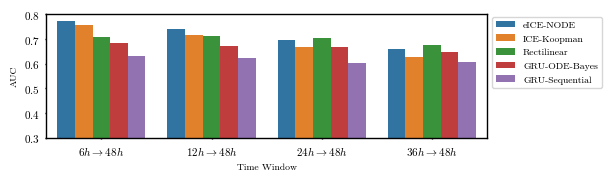

In [14]:


ax = sns.barplot(auc_top_results_df, x="Time Window", y="AUC", hue="Model", order=list(window_map.values()))
_ = ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
ax.set_ylim(0.3, 0.8)

ax.get_figure().set_size_inches(fig_width_in, fig_height_in)
ax.get_figure().savefig(f"{RESULTS_DIR}/ch_koopman_aki_top_auc_windows.pdf")

## Cost Tables: $L_f$: Forecasting MSE, $L_\text{aki}$: Early Prediction Cost, $L_f + L_\text{aki}$ 

In [15]:
cost_results_df = make_selection(results, selectors = {
    'metric': [
        'LeadPredictionLossMetric.mse',
        'ObsPredictionLossMetric.mse'
    ],
    # 'model': [
        # 'eICE-NODE', 
        # 'GRU-ODE-Bayes', 
    #     'GRU'
    # ],
    # 'predictor': [
    #     'mlp',
    #     'monotonic'
    # ],
    # 'icenode_dyn': [
    #     'mlp', 
    #     'gru', 
    #     'NA'
    # ],
    # 'loss': [
    #     'mse', 
    #     'bce'
    # ],
    # 'batch_size':
    # [
    #     64,
    #     2
    # ],
    'experiment': 
    [
        "mlp_mse_inicenodelite_g0", 
        "monotonic_bce_gruodebayes_g0", 
        # "mlp_mse_ingru_g0",
        "innaivesequentialgru_mlp_g0",
        # "innaivesequentialgru_mono_g0",
        "rectilinear_mlp_g0",
        # "rectilinear_mono_g0"
        "mlp_mse_inkoopman_g0"
    ]
})

cost_results_df['best_snapshot'] = cost_results_df.experiment.map(best_experiment_snapshot)
cost_top_results_df = cost_results_df[cost_results_df.step == cost_results_df.best_snapshot]

# cost_top_results_df.experiment = cost_top_results_df.experiment.map(experiments_map)
# cost_top_results_df = cost_top_results_df.rename(columns={"experiment": "model"})

cost_top_results_df = cost_top_results_df[['metric', 'value', 'model']]


window_map = {
    'LeadPredictionLossMetric.mse': r"$L_q$",
    'ObsPredictionLossMetric.mse': r"$L_z$",
}
cost_top_results_df.metric = cost_top_results_df.metric.map(window_map)

cost_top_results_df = cost_top_results_df.pivot(index="model", columns="metric", values="value")
cost_top_results_df[r"$L_z + L_q$"] = cost_top_results_df[r"$L_q$"] + cost_top_results_df[r"$L_z$"]
cost_top_results_df.columns.name = ''
cost_top_results_df.index.name = 'Model'
cost_top_results_df

,$L_q$,$L_z$,$L_z + L_q$
Model,,,
GRU-ODE-Bayes,0.218311,0.054221,0.272532
GRU-Sequential,0.217222,24.671970,24.889193
Koopman,0.208959,0.049842,0.258801
RectiLinear,0.205327,0.022317,0.227644
eICE-NODE,0.195042,0.021599,0.216641


In [16]:
with pd.option_context(#'styler.format.escape', 'latex',
                        #'styler.latex.multicol_align', 'c',
                        'styler.sparse.index', True,
                       'styler.format.precision', 3):
    cost_top_results_df_ = cost_top_results_df.copy()
    cost_top_results_df_.index = list(map(lambda m: rf'\texttt{{{m}}}', cost_top_results_df_.index))

    print(cost_top_results_df_.to_latex(buf=None,  header=True, 
             index=True, na_rep='NaN', escape=False, 
             multicolumn=True, 
                                        multicolumn_format='|c|', 
             multirow=True))


\begin{tabular}{lrrr}
\toprule
 & $L_q$ & $L_z$ & $L_z + L_q$ \\
\midrule
\texttt{GRU-ODE-Bayes} & 0.218 & 0.054 & 0.273 \\
\texttt{GRU-Sequential} & 0.217 & 24.672 & 24.889 \\
\texttt{Koopman} & 0.209 & 0.050 & 0.259 \\
\texttt{RectiLinear} & 0.205 & 0.022 & 0.228 \\
\texttt{eICE-NODE} & 0.195 & 0.022 & 0.217 \\
\bottomrule
\end{tabular}



## Table: Inference Time, #Dyn_Parameters, #Timestamps (binning vs free).

In [17]:
tvx_phantom = TVxEHR.load("/home/asem/GP/ehr-data/mimic4aki-cohort/tvx_aki_phantom.h5")

In [20]:
configs = {exp: Config.from_dict(load_config(os.path.join(CONFIGS_DIR, f'{exp}.json')))
           for exp in cost_results_df.experiment.unique()}
models = {exp: Experiment(config=c).load_model(tvx_phantom, 0)
          for exp, c in configs.items()}
models_dyn = {exp: m.f_dyn  if hasattr(m, 'f_dyn') else 0 for exp, m in models.items() }
model_dyn_nparams = {exp: sum(a.size for a in jtu.tree_leaves(eqx.filter(m, eqx.is_inexact_array)))
                     for exp, m in models_dyn.items()}

In [21]:
def experiment_snapshot_total_time(dataframe):
    def total_time(snapshot_df):
        return  pd.Series({
            'total_time': snapshot_df.iloc[0].updated_at - snapshot_df.iloc[0].created_at})
    return dataframe.groupby(['experiment', 'step']).apply(total_time)


def experiment_snapshot_evaluation_time(dataframe):
    eval_time_metrics = [m for m in dataframe.metric.unique() if m.endswith('.eval_time')]
    times = dataframe[dataframe.metric.isin(eval_time_metrics)].set_index(['experiment', 'step'])[['metric', 'value']]
    times.loc[:, 'value'] = times.loc[:, 'value'].map(lambda seconds: pd.Timedelta(seconds=seconds))
    times = times.pivot(columns='metric', values='value')
    times['total_time'] = times.sum(axis=1)
    return times

In [22]:
for_time_df = make_selection(results, selectors = {
    'predictor': [
        'mlp',
        'monotonic'
    ],
    'icenode_dyn': [
        'mlp', 
        'gru', 
        'NA'
    ],
    'loss': [
        'mse', 
        'bce'
    ],
    'batch_size':
    [
        64,
        2
    ],
    'experiment': 
    [
        "mlp_mse_inicenodelite_g0", 
        "monotonic_bce_gruodebayes_g0", 
        # "mlp_mse_ingru_g0",
        "innaivesequentialgru_mlp_g0",
        # "innaivesequentialgru_mono_g0",
        "rectilinear_mlp_g0",
        # "rectilinear_mono_g0"
        "mlp_mse_inkoopman_g0"
    ]
})

exp_map = for_time_df.set_index("experiment")["model"].to_dict()
# Inference + Evaluation Time
experiments_total_time = experiment_snapshot_total_time(for_time_df)
# Time per evaluation module
experiments_evaluation_time = experiment_snapshot_evaluation_time(for_time_df)
# Inference times
experiments_total_time['evaluation_time'] = experiments_evaluation_time.total_time
experiments_total_time['inference_time'] = experiments_total_time.total_time - experiments_evaluation_time.total_time
experiments_total_time_median = experiments_total_time.groupby(level=0)[experiments_total_time.columns].median()

experiments_total_time_median = experiments_total_time_median.apply(lambda x: x.dt.total_seconds() / 3600)
experiments_total_time_median = experiments_total_time_median[['inference_time']]
experiments_total_time_median.columns = ['Inference Time (h)']
experiments_stats = experiments_total_time_median.copy()
experiments_stats['#Dynamics Parameters'] = experiments_stats.index.map(model_dyn_nparams)

experiments_stats.index = experiments_stats.index.map(exp_map)
experiments_stats.index.name = "Model"

with pd.option_context('styler.format.escape', 'latex',
                        'styler.latex.multicol_align', 'c',
                        'styler.sparse.index', True):
    experiments_stats_ = experiments_stats.copy()
    experiments_stats_.index = list(map(lambda m: rf'\texttt{{{m}}}', experiments_stats_.index))
    print(experiments_stats_.style.format({"#Dynamics Parameters": "{:,.0f}", "Inference Time (h)": "{:.1f}"})
          .to_latex(buf=None))
    

\begin{tabular}{lrr}
 & Inference Time (h) & #Dynamics Parameters \\
\texttt{GRU-Sequential} & 1.5 & 0 \\
\texttt{eICE-NODE} & 27.6 & 9,150 \\
\texttt{Koopman} & 64.6 & 550,560 \\
\texttt{GRU-ODE-Bayes} & 32.9 & 11,700 \\
\texttt{RectiLinear} & 0.8 & 0 \\
\end{tabular}



## ICE-NODE Ablation.

In [ ]:
icenode_ablation_df = make_selection(results, selectors = {
    'metric': [
        'LeadPredictionLossMetric.mse',
        'ObsPredictionLossMetric.mse'
    ],
    'model': [
        'eICE-NODE'
    ],
    # 'experiment': 
    # [
    #     "monotonic_bce_inicenodelite_gru_g0", 
    #     "monotonic_bce_gruodebayes_g0", 
    #     "mlp_mse_ingru_g0"
    # ]
})

In [ ]:
icenode_ablation_df['best_snapshot'] = icenode_ablation_df.experiment.map(best_experiment_snapshot)
top_icenode_ablation_df = icenode_ablation_df[icenode_ablation_df.step == icenode_ablation_df.best_snapshot]
top_icenode_ablation_df = top_icenode_ablation_df[['experiment', 
                                                   'icenode_dyn', 'predictor',
                                                   'loss', 'batch_size',
                                                   'metric', 'value']]


window_map = {
    'LeadPredictionLossMetric.mse': r"$L_q$",
    'ObsPredictionLossMetric.mse': r"$L_z$",
}
top_icenode_ablation_df.metric = top_icenode_ablation_df.metric.map(window_map)

top_icenode_ablation_df = top_icenode_ablation_df.pivot(index=['icenode_dyn', 'predictor', 'loss', 'batch_size'], 
                                                        columns="metric", values="value")
top_icenode_ablation_df[r"$L_z + L_q$"] = top_icenode_ablation_df[r"$L_q$"] + top_icenode_ablation_df[r"$L_z$"]
top_icenode_ablation_df.index.names = ["Dynamics", "Lead Predictor", "Lead Loss", "Batch Size"]
top_icenode_ablation_df.columns.name = ''

In [ ]:
with pd.option_context('styler.format.escape', 'latex',
                        'styler.latex.multicol_align', 'c',
                        'styler.sparse.index', True):
    
    print(top_icenode_ablation_df.to_latex(buf=None, columns=None, header=True, 
             index=True, na_rep='NaN', escape=False, 
             multicolumn=True, multicolumn_format='|c|', 
             multirow=True))
